<a href="https://colab.research.google.com/github/VishnoiAman777/Efficient-FedRec/blob/main/FedRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Structure

In [1]:
%%capture
!pip install transformers

In [99]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import BertModel
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt

### MIND Dataset

In [3]:
!mkdir Dataset

In [4]:
%%capture
!mkdir Dataset/train
!mkdir Dataset/valid
!wget https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip -P Dataset/train
!unzip Dataset/train/MINDsmall_train.zip -d Dataset/train/
!rm Dataset/train/MINDsmall_train.zip
!wget https://mind201910small.blob.core.windows.net/release/MINDsmall_dev.zip -P Dataset/valid
!unzip Dataset/valid/MINDsmall_dev.zip -d Dataset/valid/
!rm Dataset/valid/MINDsmall_dev.zip
!wget https://mind201910small.blob.core.windows.net/release/MINDlarge_test.zip -P Dataset/test
!unzip Dataset/test/MINDlarge_test.zip -d Dataset/test/
!rm Dataset/test/MINDlarge_test.zip

### Preprocessing for a user

In [46]:
behaviour_df = pd.read_csv('/content/Dataset/train/behaviors.tsv',sep = '\t', index_col=0, names=['imp_id', 'UserId', 'Time', 'History', 'Samples'])

In [47]:
# Let's check out the unique users in the dataframe
users = behaviour_df.UserId
print("Number of unique users are", users.nunique())
# Let's take out a user at random and try to make a client model based on that only
luckyUser = random.choice(list(users.unique()))
print("The lucky user is for our experiment is", luckyUser)

Number of unique users are 50000
The lucky user is for our experiment is U10297


In [48]:
def saveLuckyUserData(behaviour_csv_path, news_csv_path, UID, folder_type):
    behaviour_df = pd.read_csv(behaviour_csv_path, sep = '\t', index_col=0, names=['imp_id', 'UserId', 'Time', 'History', 'Samples'])
    luckyUser_behavoiur = behaviour_df[behaviour_df.UserId == UID]
    news_by_user = []
    for index, row in luckyUser_behavoiur.iterrows():
        his = row.History
        news_by_user.extend(his.split())
        sam = [j[0] for j in [i.split("-") for i in row.Samples.split()]]
        news_by_user.extend(sam)
    news_df = pd.read_csv(news_csv_path,sep = '\t', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title Entities', 'Abstract Entites'])
    lucky_news_df = news_df.query('NewsID.isin(@news_by_user)')
    lucky_news_df.to_csv(f"LuckyUserDataset/{folder_type}/news.csv", header=False)
    luckyUser_behavoiur.to_csv(f"LuckyUserDataset/{folder_type}/behaviour.csv", header=False)

In [49]:
!mkdir LuckyUserDataset
!mkdir LuckyUserDataset/train
!mkdir LuckyUserDataset/test
!mkdir LuckyUserDataset/valid

mkdir: cannot create directory ‘LuckyUserDataset’: File exists
mkdir: cannot create directory ‘LuckyUserDataset/train’: File exists
mkdir: cannot create directory ‘LuckyUserDataset/test’: File exists
mkdir: cannot create directory ‘LuckyUserDataset/valid’: File exists


In [50]:
saveLuckyUserData("/content/Dataset/train/behaviors.tsv", "/content/Dataset/train/news.tsv", luckyUser, "train")
saveLuckyUserData("/content/Dataset/test/behaviors.tsv", "/content/Dataset/test/news.tsv", luckyUser, "test")
saveLuckyUserData("/content/Dataset/valid/behaviors.tsv", "/content/Dataset/valid/news.tsv", luckyUser, "valid")

### Preprocessing the Lucky User Data

In [51]:
post_behaviour_df_train = pd.read_csv(f"/content/LuckyUserDataset/train/behaviour.csv", index_col=0, names=['imp_id', 'UserId', 'Time', 'History', 'Samples'])
post_behaviour_df_test = pd.read_csv(f"/content/LuckyUserDataset/test/behaviour.csv", index_col=0, names=['imp_id', 'UserId', 'Time', 'History', 'Samples'])
post_behaviour_df_valid = pd.read_csv(f"/content/LuckyUserDataset/valid/behaviour.csv", index_col=0, names=['imp_id', 'UserId', 'Time', 'History', 'Samples'])

In [52]:
user_imprs = defaultdict(list)

# read user impressions
for index, l in tqdm(post_behaviour_df_train.iterrows()):
    imp_id, uid, t, his, imprs = index, l.UserId, l.Time, l.History, l.Samples
    his = his.split()
    imprs = [i.split("-") for i in imprs.split(" ")]
    neg_imp = [i[0] for i in imprs if i[1] == "0"]
    pos_imp = [i[0] for i in imprs if i[1] == "1"]
    user_imprs[uid].append([imp_id, his, pos_imp, neg_imp,0, uid])

for index, l in tqdm(post_behaviour_df_valid.iterrows()):
    imp_id, uid, t, his, imprs = index, l.UserId, l.Time, l.History, l.Samples
    his = his.split()
    imprs = [i.split("-") for i in imprs.split(" ")]
    neg_imp = [i[0] for i in imprs if i[1] == "0"]
    pos_imp = [i[0] for i in imprs if i[1] == "1"]
    user_imprs[uid].append([imp_id, his, pos_imp, neg_imp, 1, uid])

for index, l in tqdm(post_behaviour_df_test.iterrows()):
    imp_id, uid, t, his, imprs = index, l.UserId, l.Time, l.History, l.Samples
    his = his.split()
    imprs = imprs.split(" ")
    user_imprs[uid].append([imp_id, his, imprs, [], 2, uid])

2it [00:00, 1175.70it/s]
0it [00:00, ?it/s]
3it [00:00, 2740.78it/s]


In [53]:
max_his_len=50
npratio = 4
out_path = "LuckyUserDataset"
train_samples = []
valid_samples = []
test_samples = []
user_indices = defaultdict(list)

Preprocessing the `Behaviour` LuckyUserData

In [54]:
index = 0
for uid in tqdm(user_imprs):
    for impr in user_imprs[uid]:
        imp_id, his, poss, negs, is_valid, uid = impr
        his = his[-max_his_len:]
        if is_valid == 0:
            for pos in poss:
                train_samples.append([imp_id, pos, negs, his, uid])
                user_indices[uid].append(index)
                index += 1
        elif is_valid == 1:
            valid_samples.append([imp_id, poss, negs, his, uid])
        else:
            test_samples.append([imp_id, poss, negs, his, uid])

print(len(train_samples), len(valid_samples), len(test_samples))

with open(out_path + "/train_sam_uid.pkl", "wb") as f:
    pickle.dump(train_samples, f)

with open(out_path + "/valid_sam_uid.pkl", "wb") as f:
    pickle.dump(valid_samples, f)

with open(out_path + "/test_sam_uid.pkl", "wb") as f:
    pickle.dump(test_samples, f)

with open(out_path + "/user_indices.pkl", "wb") as f:
    pickle.dump(user_indices, f)

train_user_samples = 0

for uid in tqdm(user_indices):
    train_user_samples += len(user_indices[uid])

print(train_user_samples / len(user_indices))

100%|██████████| 1/1 [00:00<00:00, 6574.14it/s]


4 0 3


100%|██████████| 1/1 [00:00<00:00, 562.69it/s]

4.0


Preprocessing the `News` LuckyUserData

In [55]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [56]:
max_title_len= 30
post_news_df_train = pd.read_csv('/content/LuckyUserDataset/train/news.csv', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title Entities', 'Abstract Entites'])
post_news_df_test = pd.read_csv('/content/LuckyUserDataset/test/news.csv', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title Entities', 'Abstract Entites'])
post_news_df_valid = pd.read_csv('/content/LuckyUserDataset/valid/news.csv', names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title Entities', 'Abstract Entites'])

In [57]:
# news preprocess
nid2index = {"<unk>": 0}
news_index = [[[0] * max_title_len, [0] * max_title_len]]
for index, l in post_news_df_train.iterrows():
    nid, vert, subvert, title, abst, url, ten, aen = l.NewsID, l.Category, l.SubCategory, l.Title, l.Abstract, l.URL, l["Title Entities"], l["Abstract Entites"]
    if nid in nid2index:
        continue
    tokens = tokenizer(
        title,
        max_length=max_title_len,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
    )
    nid2index[nid] = len(nid2index)
    news_index.append([tokens.input_ids, tokens.attention_mask])

for index, l in post_news_df_valid.iterrows():
    nid, vert, subvert, title, abst, url, ten, aen = l.NewsID, l.Category, l.SubCategory, l.Title, l.Abstract, l.URL, l["Title Entities"], l["Abstract Entites"]
    if nid in nid2index:
        continue
    tokens = tokenizer(
        title,
        max_length=max_title_len,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
    )
    nid2index[nid] = len(nid2index)
    news_index.append([tokens.input_ids, tokens.attention_mask])

with open(out_path + "/bert_nid2index.pkl", "wb") as f:
    pickle.dump(nid2index, f)

news_index = np.array(news_index)
np.save(out_path + "/bert_news_index", news_index)

# Preparing the test data

nid2index = {"<unk>": 0}
news_index = [[[0] * max_title_len, [0] * max_title_len]]

for index, l in post_news_df_test.iterrows():
    nid, vert, subvert, title, abst, url, ten, aen = l.NewsID, l.Category, l.SubCategory, l.Title, l.Abstract, l.URL, l["Title Entities"], l["Abstract Entites"]
    if nid in nid2index:
        continue
    tokens = tokenizer(
        title,
        max_length=max_title_len,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
    )
    nid2index[nid] = len(nid2index)
    news_index.append([tokens.input_ids, tokens.attention_mask])

with open(out_path + "/bert_test_nid2index.pkl", "wb") as f:
    pickle.dump(nid2index, f)

news_index = np.array(news_index)
np.save(out_path + "/bert_test_news_index", news_index)


### Training User model

For this Experiment I will be using DistillBert for generating Embeddings compared to Bert the original paper used because it has 40% less parameters and can run smoothly on client side

In [58]:
from pathlib import Path
data_path = Path("LuckyUserDataset")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### News Dataset Class:
This class just returns distil_bert title and it's curresponding mask for a particular news

In [59]:
# This class just returns distil_bert title and it's curresponding mask for a particular news
class NewsDataset(Dataset):
    def __init__(self, news_index):
        self.news_index = news_index

    def __len__(self):
        return len(self.news_index)

    def __getitem__(self, idx):
        return self.news_index[idx]

### News Part Dataset
Return `<token, attention_mask>` curresponding to a particular NewsID

In [60]:
class NewsPartDataset(Dataset):
    def __init__(self, news_index, nids):
        self.news_index = news_index
        self.nids = nids

    def __len__(self):
        return len(self.nids)

    def __getitem__(self, idx):
        nid = self.nids[idx]
        return nid, self.news_index[nid]

### Additive Attention
This class contains the additive Attention Module that contains word Embeddings into a sentence Embeddings

In [61]:
class AdditiveAttention(nn.Module):
    def __init__(self, d_h, hidden_size=200):
        super(AdditiveAttention, self).__init__()
        self.att_fc1 = nn.Linear(d_h, hidden_size)
        self.att_fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x, attn_mask=None):
        bz = x.shape[0]
        e = self.att_fc1(x)
        e = nn.Tanh()(e)
        alpha = self.att_fc2(e)
        alpha = torch.exp(alpha)
        if attn_mask is not None:
            alpha = alpha * attn_mask.unsqueeze(2)
        alpha = alpha / (torch.sum(alpha, dim=1, keepdim=True) + 1e-8)

        x = torch.bmm(x.permute(0, 2, 1), alpha)
        x = torch.reshape(x, (bz, -1))  # (bz, 400)
        return x

### Text Encoder
This class contains the text Encoder DistillBert + Additive Attention which will return the textual Embedding of a particular News

In [76]:
class TextEncoder(nn.Module):
    def __init__(self,
                 word_embedding_dim=400,
                 dropout_rate=0.2,
                 enable_gpu=True):
        super(TextEncoder, self).__init__()
        self.dropout_rate = 0.2
        self.DistillBert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.additive_attention = AdditiveAttention(self.DistillBert.config.hidden_size,
                                                    self.DistillBert.config.hidden_size // 2)
        self.fc = nn.Linear(self.DistillBert.config.hidden_size, word_embedding_dim)

    def forward(self, text):
        tokens = text[:, 0, :]
        atts = text[:, 1, :]
        text_vector = self.DistillBert(tokens, attention_mask=atts)[0]
        text_vector = self.additive_attention(text_vector)
        text_vector = self.fc(text_vector)
        return text_vector

### UserHistory Encoder
This encodes the userHistory by using MultiHead Attention + Additive Attention Module

In [77]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k

    def forward(self, Q, K, V, attn_mask=None):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d_k)
        scores = torch.exp(scores)
        if attn_mask is not None:
            scores = scores * attn_mask
        attn = scores / (torch.sum(scores, dim=-1, keepdim=True) + 1e-8)

        context = torch.matmul(attn, V)
        return context, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model  # 300
        self.n_heads = n_heads  # 20
        self.d_k = d_k  # 20
        self.d_v = d_v  # 20

        self.W_Q = nn.Linear(d_model, d_k * n_heads)  # 300, 400
        self.W_K = nn.Linear(d_model, d_k * n_heads)  # 300, 400
        self.W_V = nn.Linear(d_model, d_v * n_heads)  # 300, 400

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)

    def forward(self, Q, K, V, attn_mask=None):
        batch_size, seq_len, _ = Q.size()

        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)

        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(1).expand(batch_size, seq_len, seq_len)
            attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)

        context, attn = ScaledDotProductAttention(self.d_k)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)
        return context

### News Updator Dataset

In [78]:
class NewsUpdatorDataset(Dataset):
    def __init__(self, news_index, news_ids, news_grads):
        self.news_index = news_index
        self.news_grads = news_grads
        self.news_ids = news_ids

    def __len__(self):
        return len(self.news_ids)

    def __getitem__(self, idx):
        nid = self.news_ids[idx]
        return self.news_index[nid], self.news_grads[idx]

### User Model
This class contains the user model

In [79]:
class UserEncoder(nn.Module):
    def __init__(self,
                 news_embedding_dim=400,
                 num_attention_heads=20,
                 query_vector_dim=200
                 ):
        super(UserEncoder, self).__init__()
        self.dropout_rate = 0.2
        self.multihead_attention = MultiHeadAttention(news_embedding_dim,
                                                      num_attention_heads, 20, 20)
        self.additive_attention = AdditiveAttention(news_embedding_dim,
                                                    query_vector_dim)

    def forward(self, clicked_news_vecs):
        clicked_news_vecs = F.dropout(clicked_news_vecs, p=self.dropout_rate, training=self.training)
        multi_clicked_vectors = self.multihead_attention(
            clicked_news_vecs, clicked_news_vecs, clicked_news_vecs
        )
        pos_user_vector = self.additive_attention(multi_clicked_vectors)
        user_vector = pos_user_vector
        return user_vector


In [80]:
class UserModel(nn.Module):
    def __init__(self, news_dataset, news_index, 
                 device, news_embedding_dim=400,
                 num_attention_heads=20,
                 query_vector_dim=200):
        
        super(UserModel, self).__init__()
        self.device = device

        self.text_encoder = TextEncoder().to(device)
        self.user_encoder = UserEncoder().to(device)

        self.news_optimizer = optim.Adam(self.text_encoder.parameters(), lr=0.00005)
        self.user_optimizer = optim.Adam(self.user_encoder.parameters(), lr=0.00005)

        for param in self.text_encoder.DistillBert.parameters():
            param.requires_grad = False
        
        self.news_dataset = news_dataset
        self.news_index = news_index

        self.time = 0
        self.cnt = 0
        self.criterion = nn.CrossEntropyLoss()
        self._init_grad_param()

    def _init_grad_param(self):
        self.news_grads = {}
        self.user_optimizer.zero_grad()
        self.news_optimizer.zero_grad()

    def gen_news_vecs(self, nids):
        self.text_encoder.eval()
        news_vectors = []
        for i in nids:
            news_ds = NewsPartDataset(self.news_index, i)
            news_dl = DataLoader(news_ds, batch_size=2048, shuffle=False, num_workers=0)
            """
            A dataloader that containers nid, news_index
            """
            # news_vecs = np.zeros((npratio, 400), dtype='float32')
            news_vecs = []
            with torch.no_grad():
                for nids, news in news_dl:
                    news = news.to(self.device)
                    news_vec = self.text_encoder(news).detach().cpu().numpy()
                    # news_vecs[nids.numpy()] = news_vec
                    news_vecs=news_vec
            if np.isnan(news_vecs).any():
                raise ValueError("news_vecs contains nan")
            news_vectors.append(news_vecs)
        return news_vectors

    def get_news_vecs(self, idx):
        return self.news_vecs[idx]

    def update(self):
        self.update_user_grad()
        self.update_news_grad()
        self._init_grad_param()
        self.cnt += 1

    def average_update_time(self):
        return self.time / self.cnt

    def update_news_grad(self):
        self.text_encoder.train()
        self.news_optimizer.zero_grad()

        news_ids, news_grads = [], []
        for nid in self.news_grads:
            news_ids.append(nid)
            news_grads.append(self.news_grads[nid])

        news_up_ds = NewsUpdatorDataset(self.news_index, news_ids, news_grads)
        news_up_dl = DataLoader(news_up_ds, batch_size=128, shuffle=False, num_workers=0)
        for news_index, news_grad in news_up_dl:
            news_index = news_index.to(self.device)
            news_grad = news_grad.to(self.device)
            news_vecs = self.text_encoder(news_index)
            news_vecs.backward(news_grad)

        self.news_optimizer.step()
        self.news_optimizer.zero_grad()

    def update_user_grad(self):
        self.user_optimizer.step()
        self.user_optimizer.zero_grad()

    def check_news_vec_same(self, nids, news_vecs):
        assert (self.get_news_vecs(nids) == news_vecs).all(), "News vecs are not the same"

    def collect(self, news_grad, user_grad):
        # update user model params
        for name, param in self.user_encoder.named_parameters():
            if param.grad is None:
                param.grad = user_grad[name]
            else:
                param.grad += user_grad[name]
        # update news model params
        for nid in news_grad:
            if nid in self.news_grads:
                self.news_grads[nid] += news_grad[nid]
            else:
                self.news_grads[nid] = news_grad[nid]

    def forward(self, candidate_news, his_news, labels, compute_loss=True):
        # print("Model is being called")
        candidate_vecs = torch.as_tensor(np.array(self.gen_news_vecs(candidate_news))).to(self.device)
        # print("Successfully calculated the candidate vector")

        his_vec = torch.as_tensor(np.array(self.gen_news_vecs(his_news))).to(self.device)
        # print("Successfully calculated the history vectors")

        candidate_vecs.requires_grad = True
        his_vec.requires_grad = True

        # print("Shape of candidate_news", np.array(candidate_news).shape)
        # print("Shape of history news", np.array(his_news).shape)
        # print("The shape of candidate_vecs", candidate_vecs.shape)
        # print("The shape of his vecs", his_vec.shape)

        user_vector = self.user_encoder(his_vec)    

        score = torch.bmm(candidate_vecs, user_vector.unsqueeze(-1)).squeeze(dim=-1)
       
        score = torch.sigmoid(score)

        if compute_loss:
            loss = self.criterion(score, labels)
            return loss, score, candidate_vecs, his_vec
        else:
            return score, candidate_vecs, his_vec

# Training Starts Here

### Loading the client's data

In [81]:
# Loading all the data for our LuckyUser
with open(data_path / "bert_nid2index.pkl", "rb") as f:
    nid2index = pickle.load(f)

news_index = np.load(data_path / "bert_news_index.npy", allow_pickle=True)

with open(data_path / "train_sam_uid.pkl", "rb") as f:
    train_sam = pickle.load(f)

with open(data_path / "valid_sam_uid.pkl", "rb") as f:
    valid_sam = pickle.load(f)

with open(data_path / "test_sam_uid.pkl", "rb") as f:
    test_sam = pickle.load(f)

### Train DataLoader
This class creates a training dataloader and returns a batch of `candidate_news, candidate_news_vecs, his, his_vecs, label` when called forward 

In [82]:
def newsample(nnn, ratio):
    if ratio > len(nnn):
        return nnn + ["<unk>"] * (ratio - len(nnn))
    else:
        return random.sample(nnn, ratio)

In [83]:
class TrainDataset(Dataset):
    def __init__(self, train_sam, nid2index, news_index):
        # Here samples is same as train_sam_uid stuff 
        self.news_index = news_index
        self.nid2index = nid2index
        self.train_sam = train_sam

    def __len__(self):
        return len(self.train_sam)

    def __getitem__(self, idx):
        # pos, neg, his, neg_his
        _, pos, neg, his, _ = self.train_sam[idx]
        neg = newsample(neg, npratio)
        candidate_news = np.array([self.nid2index[n] for n in [pos] + neg])
        his = np.array([self.nid2index[n] for n in his] + [0] * (max_his_len - len(his)))
        label = np.array(0)
        return candidate_news, his, label

### Validation Script

In [84]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

def dcg_score(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10):
    best = dcg_score(y_true, y_true, k)
    actual = dcg_score(y_true, y_score, k)
    return actual / best


def mrr_score(y_true, y_score):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)
    rr_score = y_true / (np.arange(len(y_true)) + 1)
    return np.sum(rr_score) / np.sum(y_true)


def compute_amn(y_true, y_score):
    auc = roc_auc_score(y_true,y_score)
    mrr = mrr_score(y_true,y_score)
    ndcg5 = ndcg_score(y_true,y_score,5)
    ndcg10 = ndcg_score(y_true,y_score,10)
    return auc, mrr, ndcg5, ndcg10

In [85]:
def evaluation_split(news_vecs, user_vecs, samples, nid2index):
    all_rslt = []
    for i in tqdm(range(len(samples))):
        _, poss, negs, _, _ = samples[i]
        user_vec = user_vecs[i]
        y_true = [1] * len(poss) + [0] * len(negs)
        news_ids = [nid2index[i] for i in poss + negs]
        news_vec = news_vecs[news_ids]
        y_score = np.multiply(news_vec, user_vec)
        y_score = np.sum(y_score, axis=1)
        try:
            all_rslt.append(compute_amn(y_true, y_score))
        except Exception as e:
            print(e)
    return np.array(all_rslt)

In [86]:
class UserDataset(Dataset):
    def __init__(self,
                 args,
                 samples,
                 news_vecs,
                 nid2index):
        self.samples = samples
        self.args = args
        self.news_vecs = news_vecs
        self.nid2index = nid2index

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        _, poss, negs, his, _ = self.samples[idx]
        his = [self.nid2index[n] for n in his] + [0] * (self.args.max_his_len - len(his))
        his = self.news_vecs[his]
        return his

In [87]:
def validate(model, valid_sam, nid2index, news_index, device):
    # agg.gen_news_vecs(list(range(len(news_index))))
    # model.user_encoder.eval()
    model.eval()
    news_vectors = model.gen_news_vecs()
    user_dataset = UserDataset(valid_sam, agg.news_vecs, nid2index)
    """Returns history for a particular user"""
    user_vecs = []
    user_dl = DataLoader(user_dataset, batch_size=4096, shuffle=False, num_workers=0)
    with torch.no_grad():
        for his in tqdm(user_dl):
            his = his.to(device)
            user_vec = agg.user_encoder(his).detach().cpu().numpy()
            user_vecs.append(user_vec)
    user_vecs = np.concatenate(user_vecs)

    val_scores = evaluation_split(agg.news_vecs, user_vecs, valid_sam, nid2index)
    val_auc, val_mrr, val_ndcg, val_ndcg10 = [
        np.mean(i) for i in list(zip(*val_scores))
    ]

    return val_auc, val_mrr, val_ndcg, val_ndcg10

### Training for each epoch

In [88]:
max_train_steps = 500
user_lr = 0.00005

In [89]:
def process_news_grad(candidate_info, his_info):
    news_grad = {}
    candidate_news, candidate_vecs, candidate_grad = candidate_info
    his, his_vecs, his_grad = his_info

    candidate_news, candaidate_grad = (
        candidate_news.reshape(-1, ),
        candidate_grad.reshape(-1, 400),
    )
    his, his_grad = his.reshape(-1, ), his_grad.reshape(-1, 400)

    for nid, grad in zip(his, his_grad):
        if nid in news_grad:
            news_grad[nid] += grad
        else:
            news_grad[nid] = grad

    for nid, grad in zip(candidate_news, candaidate_grad):
        if nid in news_grad:
            news_grad[nid] += grad
        else:
            news_grad[nid] = grad
    return news_grad

In [90]:
def process_user_grad(model_param):
    user_grad = {}
    for name, param in model_param:
        user_grad[name] = param.grad
    return user_grad

In [94]:
def train_on_step(model, user_indices, train_sam, nid2index, news_index, device):
    # These are generating news vectors from transformers for given nids
    train_ds = TrainDataset(train_sam, nid2index, news_index)
    """ 
    Train_ds returns
    candidate_news: Integer currsponding to news watched by one user sampled from set of users, 
    his: History of a user curresponding to a user, 
    label: 0
    """

    train_dl = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=0)
    model.train()
    loss = 0

    for cnt, batch_sample in enumerate(train_dl):
        # model.user_encoder.load_state_dict(agg.user_encoder.state_dict())
        optimizer = optim.SGD(model.parameters(), lr=user_lr)

        candidate_news, his, label = batch_sample

        bz_loss, y_hat, candidate_news_vecs, his_vecs = model(candidate_news, his, label)
        loss += bz_loss.detach().cpu().numpy()

        print("The loss we have encountered is", loss)

        optimizer.zero_grad()
        bz_loss.backward()

        candaidate_grad = candidate_news_vecs.grad.detach().cpu() 

        candidate_vecs = candidate_news_vecs.detach().cpu().numpy()
        candidate_news = candidate_news.numpy()

        his_grad = his_vecs.grad.detach().cpu() 
        his_vecs = his_vecs.detach().cpu().numpy()
        his = his.numpy()

        news_grad = process_news_grad(
            [candidate_news, candidate_vecs, candaidate_grad], [his, his_vecs, his_grad]
        )
        """
        Return a news grad: a dic that contains nid: gradient_curresponding to that news
        """

        user_grad = process_user_grad(
            model.user_encoder.named_parameters()
        )
        model.collect(news_grad, user_grad)

    model.update()
    return loss

In [97]:
news_dataset = NewsDataset(news_index)
model = UserModel(news_dataset, news_index, device).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
iteration = []
loss_train = []
for i in range(10):
    loss = train_on_step(
            model,
            user_indices,
            train_sam,
            nid2index,
            news_index,
            device,
        )
    iteration.append(i)
    loss_train.append(loss)

The loss we have encountered is 1.6263298988342285
The loss we have encountered is 1.5809887647628784
The loss we have encountered is 1.5777842998504639
The loss we have encountered is 1.5222123861312866
The loss we have encountered is 1.473042368888855
The loss we have encountered is 1.4577553272247314
The loss we have encountered is 1.4685317277908325
The loss we have encountered is 1.3857804536819458
The loss we have encountered is 1.3778367042541504
The loss we have encountered is 1.3351210355758667


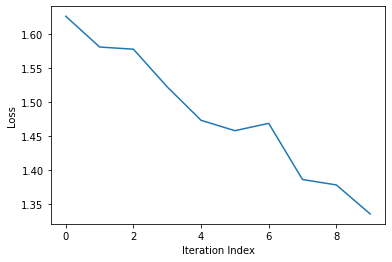

In [101]:
plt.plot(iteration, loss_train)
plt.xlabel('Iteration Index')
plt.ylabel('Loss')
plt.show()

In [ ]:
best_auc = 0
for step in range(max_train_steps):
    loss = train_on_step(
        model,
        user_indices,
        train_sam,
        nid2index,
        news_index,
        device,
    )

    # wandb.log({"train loss": loss}, step=step + 1)

    if (step + 1) % validation_steps == 0:
        val_auc, val_mrr, val_ndcg, val_ndcg10 = validate(
        agg, valid_sam, nid2index, news_index, device
        )

        # wandb.log(
        #     {
        #         "valid auc": val_auc,
        #         "valid mrr": val_mrr,
        #         "valid ndcg@5": val_ndcg,
        #         "valid ndcg@10": val_ndcg10,
        #     },
        #   

        with open(out_path / f"log.txt", "a") as f:
            f.write(
                f"[{step}] round auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n"
            )

        if val_auc > best_auc:
            best_auc = val_auc
            wandb.run.summary["best_auc"] = best_auc
            torch.save(
                {
                    "text_encoder": agg.text_encoder.state_dict(),
                    "user_encoder": agg.user_encoder.state_dict(),
                },
                out_model_path / f"{args.name}-{args.data}.pkl",
            )

            with open(out_path / f"log.txt", "a") as f:
                f.write(f"[{step}] round save model\n")